# Step 0 - Data Exploration and Preparation

## Overview


해당 코드는 카메라 이미지와 차량의 상태정보(조향 각도)를 기반으로 하여 차량의 운전 방향을 예측하는 심층 학습 모델을 위한 것이다. 학습 모델은 End-to-End Model을 위해 데이터를 전처리는 하는 과정이다.  


## What is end-to-end deep learning?

End-to-end deep learning은 기존의 deep learning과의 차이점은 feature engineering을 하지 않는다. 대신 GPU를 통한 대용량 데이터 처리를 통해 원시적인 입력을 통해 출력을 직접적으로 매핑할 수 있다. 그렇기 때문에 전통적인 기계학습보다 인간과 유사한 학습이 가능한 점이 장점이다. 그러나 이 방법은 매우 많은 양의 학습 데이터가 필요하여, 일반적으로 적용하기가 어렵다. 시뮬레이터의 경우 무한한 양의 데이터를 생성할 수 있어, end-to-to deep learning을 적용하기에 적합하다. 

실제 차량을 사용하지 않고, Airsim과 같은 자율 주행 시뮬레이터를 활용하면 많은 학습 데이터를 수집할 수 있다. 또한 적응 양의 데이터로 코딩을 통해 각각의 제어 가능한 입력들을 미세하게 조정할 수가 있다. 해당 코드들은 생성된 데이터 셋을 분석하여, 주어진 입력에 따라 조향 각도를 예측하는 것이다. 입력으로는 자동차의 속도, 조향각도, 스로틀 등으로 표기된다.



In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import Cooking
import random

# << Point this to the directory containing the raw data >>
RAW_DATA_DIR = 'E:/Airsim_data/data_raw/'

# << Point this to the desired output directory for the cooked (.h5) data >>
COOKED_DATA_DIR = 'E:/Airsim_data/data_cooked/'

# The folders to search for data under RAW_DATA_DIR
# For example, the first folder searched will be RAW_DATA_DIR/normal_1
DATA_FOLDERS = ['normal_1', 'normal_2','normal_3','normal_4','normal_5','normal_6','normal_7',
                'swerve_1','swerve_2','swerve_3']
                #,'swerve_1', 'swerve_2', 'swerve_3']
#DATA_FOLDERS = ['normal_1', 'swerve_1'] 

# The size of the figures in this notebook
FIGURE_SIZE = (10,10)

시뮬레이터로 데이터를 생성하면, 해당 디렉터리에 이미지(.png)파일과 txt 파일이 생성된다.

In [2]:
sample_tsv_path = os.path.join(RAW_DATA_DIR, 'normal_1/airsim_rec.txt')
sample_tsv = pd.read_csv(sample_tsv_path, sep='\t')
sample_tsv.head()

,Timestamp,Speed (kmph),Throttle,Steering,Brake,Gear,ImageName
0,1530197106309,0,0.000000,0.0,0.0,1,img_0_0_1530197106348668500.png
1,1530197106404,0,0.000000,0.0,0.0,1,img_0_0_1530197106429196100.png
2,1530197106484,0,0.000000,0.0,0.0,1,img_0_0_1530197106509346700.png
3,1530197106565,0,0.000000,0.0,0.0,1,img_0_0_1530197106590442100.png
4,1530197106644,0,0.015686,0.0,0.0,1,img_0_0_1530197106670374300.png


해당 데이터 셋에는 타임스탬프 별로 속도, 스로틀(액셀), 조향 각, 브레이크, 기어 등이 표시된다. 그리고 각 시점별로 이미지로 기록되어 있다.

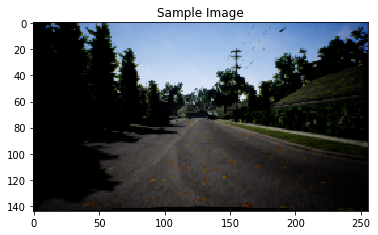

In [3]:
sample_image_path = os.path.join(RAW_DATA_DIR, 'normal_1/images/'+sample_tsv.ImageName[0])
sample_image = Image.open(sample_image_path)
plt.title('Sample Image')
plt.imshow(sample_image)
plt.show()

위의 이미지를 예시를 보여주며, 우리는 이미지의 모두를 활용하지 않고, **일부만을 사용**한다. 빨간색으로 표시된 이미지의 ROI(Region of Interest)에 집중하여, 자동차의 조향 각도를 결정하게 된다.

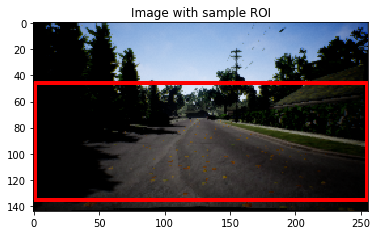

In [4]:
sample_image_roi = sample_image.copy()

fillcolor=(255,0,0)
draw = ImageDraw.Draw(sample_image_roi)
points = [(1,46), (1,135), (255,135), (255,46)]
for i in range(0, len(points), 1):
    draw.line([points[i], points[(i+1)%len(points)]], fill=fillcolor, width=3)
del draw

plt.title('Image with sample ROI')
plt.imshow(sample_image_roi)
plt.show()

**ROI를 추출하여 학습 모델에 활용하여, 불필요한 주변 환경(산, 구름 등)에 대한 계산을 하지않아, 실제 학습에 필요한 시간과, 데이터 양을 줄일 수 있다.** 따라서, 더 최적화된 모델을 생성할 수 있다.   

**추후 Train 시 시에는 조명 조건의 변화에 영향을 받지 않아야 하므로, 이미지의 밝기를 전체적으로 올려서 학습에 활용함**


In [5]:
full_path_raw_folders = [os.path.join(RAW_DATA_DIR, f) for f in DATA_FOLDERS]

dataframes = []
for folder in full_path_raw_folders:
    current_dataframe = pd.read_csv(os.path.join(folder, 'airsim_rec.txt'), sep='\t')
    current_dataframe['Folder'] = folder
    dataframes.append(current_dataframe)
    
dataset = pd.concat(dataframes, axis=0)

print('Number of data points: {0}'.format(dataset.shape[0]))

dataset.head()

Number of data points: 32015


,Timestamp,Speed (kmph),Throttle,Steering,Brake,Gear,ImageName,Folder
0,1530197106309,0,0.000000,0.0,0.0,1,img_0_0_1530197106348668500.png,E:/Airsim_data/data_raw/normal_1
1,1530197106404,0,0.000000,0.0,0.0,1,img_0_0_1530197106429196100.png,E:/Airsim_data/data_raw/normal_1
2,1530197106484,0,0.000000,0.0,0.0,1,img_0_0_1530197106509346700.png,E:/Airsim_data/data_raw/normal_1
3,1530197106565,0,0.000000,0.0,0.0,1,img_0_0_1530197106590442100.png,E:/Airsim_data/data_raw/normal_1
4,1530197106644,0,0.015686,0.0,0.0,1,img_0_0_1530197106670374300.png,E:/Airsim_data/data_raw/normal_1


** 데이터 셋 이름을 각각 Normal, Swerve로 지정하여 2개의 유형을 함께 학습 시켰다.** 각각의 차이는 Steering의 각도에 있어, 확연한 차이가 있음을 알 수 있다.**우리가 알고자하는 운전 주행 스타일의 차이점**을 알기 위한 중요한 부분이다.

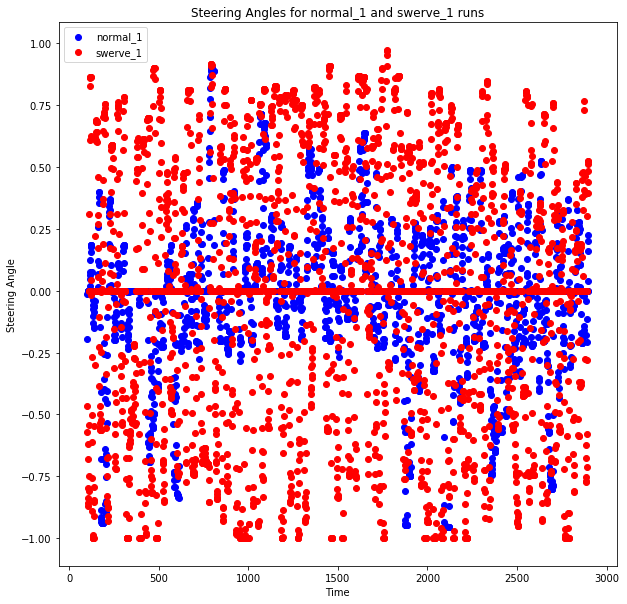

In [10]:
min_index = 100
max_index = 2900
steering_angles_normal_1 = dataset[dataset['Folder'].apply(lambda v: 'normal_1' in v)]['Steering'][min_index:max_index]
steering_angles_swerve_1 = dataset[dataset['Folder'].apply(lambda v: 'swerve_1' in v)]['Steering'][min_index:max_index]

plot_index = [i for i in range(min_index, max_index, 1)]

fig = plt.figure(figsize=FIGURE_SIZE)
ax1 = fig.add_subplot(111)

ax1.scatter(plot_index, steering_angles_normal_1, c='b', marker='o', label='normal_1')
ax1.scatter(plot_index, steering_angles_swerve_1, c='r', marker='o', label='swerve_1')
plt.legend(loc='upper left');
plt.title('Steering Angles for normal_1 and swerve_1 runs')
plt.xlabel('Time')
plt.ylabel('Steering Angle')
plt.show()

데이터 셋의 그래프를 보면, Normal와 Swerve의 확연차이를 볼 수 있다. 그래프 내 파란 점(normal)은 일반적인 주행 모델을 나타내며, 빨간 점(swerve)은 주행 시, 좌우로 계속 움직이는 운전 스타일을 나타낸다. 

**이렇게 학습을 시키는 것은 end-to-end deep learning model를 통해 정상적인 주행을 시키기 위해 매우 중요한 작업이다.** 우리가 학습 시키는 모델에서는 feature engineering을 하지 않기 때문에, recall 작업에 필요한 정보를 온전히 dataset에만 의존하기 때문이다. 따라서, 모델이 학습 결과에 따라 주행할 때, 급 커브 또는 도로 에서 벗어날 때, 자체적으로 교정할 수 있는 경우를 해주기 위해서 일부의 swerve 학습 모델이 필요하다. 그러므로 길 한 가운데에만 주행하는 정상적인 데이터로만 학습을 한 결과, 정상적인 주행이 어려우며, 지속적인 주행이 어려운 것을 관찰할 수 있다. 


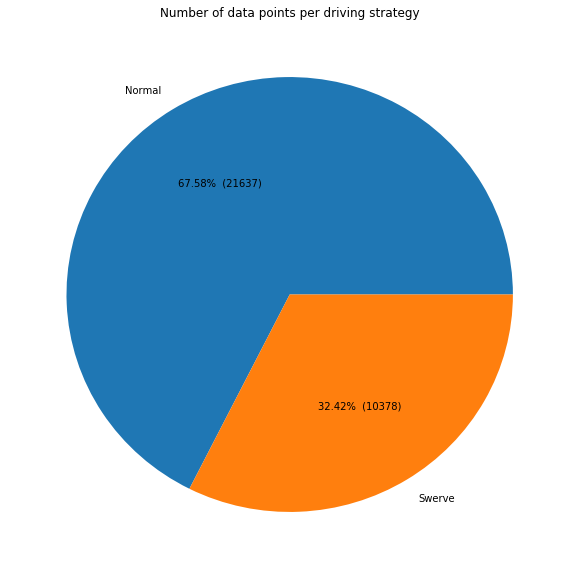

In [12]:
dataset['Is Swerve'] = dataset.apply(lambda r: 'swerve' in r['Folder'], axis=1)
grouped = dataset.groupby(by=['Is Swerve']).size().reset_index()
grouped.columns = ['Is Swerve', 'Count']

def make_autopct(values):
    def my_autopct(percent):
        total = sum(values)
        val = int(round(percent*total/100.0))
        return '{0:.2f}%  ({1:d})'.format(percent,val)
    return my_autopct

pie_labels = ['Normal', 'Swerve']
fig, ax = plt.subplots(figsize=FIGURE_SIZE)
ax.pie(grouped['Count'], labels=pie_labels, autopct = make_autopct(grouped['Count']))
plt.title('Number of data points per driving strategy')
plt.show()

위의 그래프를 보면, 학습에 사용하는 데이터 포인트의 수가 약 32,000개가 된다는 것을 알 수 있다. 그 중 약 70%가 정상적인 주행 데이터로 수집되고, 나머지 30%정도가 차량의 탈선 또는 정해진 곳이 아닌 곳을 주행하는 것을 방지하기 위한 경우를 학습하기 위한 용도로 사용된다. 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


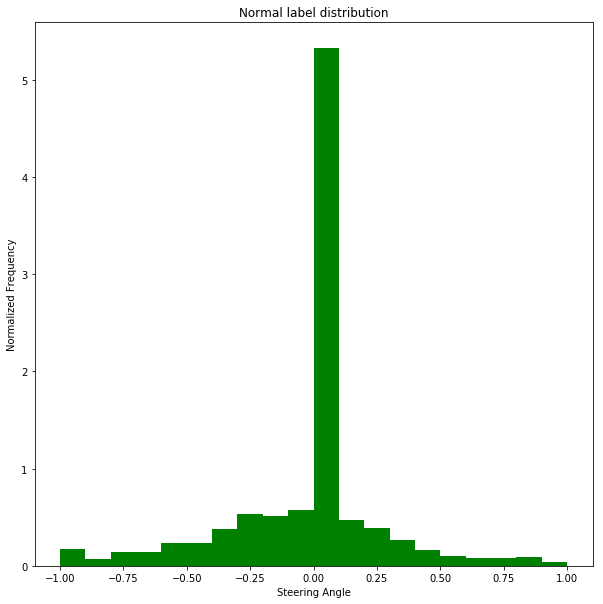

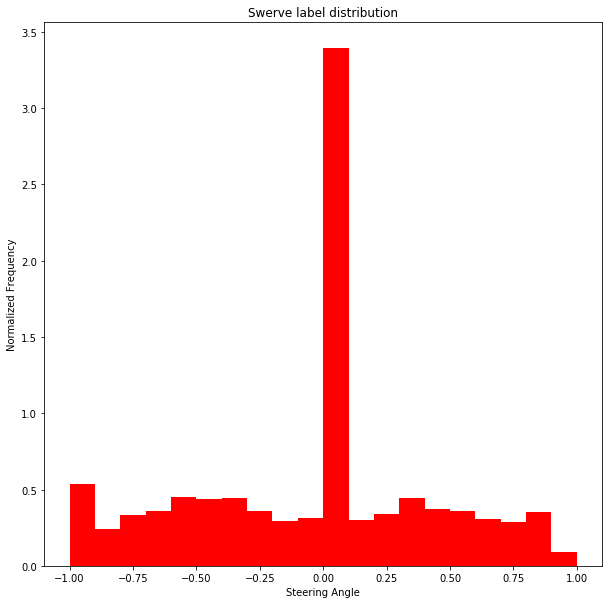

In [13]:
bins = np.arange(-1, 1.05, 0.1)
normal_labels = dataset[dataset['Is Swerve'] == False]['Steering']
swerve_labels = dataset[dataset['Is Swerve'] == True]['Steering']

def steering_histogram(hist_labels, title, color):
    plt.figure(figsize=FIGURE_SIZE)
    n, b, p = plt.hist(hist_labels.as_matrix(), bins, normed=1, facecolor=color)
    plt.xlabel('Steering Angle')
    plt.ylabel('Normalized Frequency')
    plt.title(title)
    plt.show()

steering_histogram(normal_labels, 'Normal label distribution', 'g')
steering_histogram(swerve_labels, 'Swerve label distribution', 'r')


위의 그래프를 통해 Normal과 Swerve의 조향 각도 분포 차이를 확연하고 관찰할 수 있다.

* **코너가 아닌 경우에는 대부분은 조향 각도는 0이라는 것을 알 수 있다.** 또한, Normal(Green)의 나타나는 0의 수치보다 Swerve(Red)에서 나타나는 0의 빈도가 확연하게 낮다는 것도 알 수 있다. 하지만, 두 경우 모두 0의 빈도가 상당히 많으므로 실제 학습을 할 때에는 downsample을 통해 0의 빈도를 확연하게 낮춰야 정상적인 주행이 가능한 것을 알 수 있다. 

* **빈도의 차이를 보면, Normal에서는 정규 분포에 따라 고르게 분포된 반면, Swerve에서는 매우 균등하게 분포되어 있다.** 또한, 급한 커브를 나타내는 -1, 1 의 빈도가 Normal 주행인 경우보다 상대적으로 많이 분포되어 있다.

다음은 **원시 데이터를 학습에 적합한 데이터 파일로 merge 작업을 해야 한다. 파일 형식은 .h5를 사용한다.** h5 파일 형태는 모든 것을 한꺼번에 읽지 않아, 큰 데이터 셋을 활용하는데 매우 이상적이다. Keras와의 호환성도 좋다.|

In [18]:
train_eval_test_split = [0.7, 0.2, 0.1]
full_path_raw_folders = [os.path.join(RAW_DATA_DIR, f) for f in DATA_FOLDERS]
Cooking.cook(full_path_raw_folders, COOKED_DATA_DIR, train_eval_test_split)

Reading data from E:/Airsim_data/data_raw/normal_1...
Reading data from E:/Airsim_data/data_raw/normal_2...
Reading data from E:/Airsim_data/data_raw/normal_3...
Reading data from E:/Airsim_data/data_raw/normal_4...
Reading data from E:/Airsim_data/data_raw/normal_5...
Reading data from E:/Airsim_data/data_raw/normal_6...
Reading data from E:/Airsim_data/data_raw/normal_7...
Reading data from E:/Airsim_data/data_raw/swerve_1...
Reading data from E:/Airsim_data/data_raw/swerve_2...
Reading data from E:/Airsim_data/data_raw/swerve_3...
Processing E:/Airsim_data/data_cooked/train.h5...
Finished saving E:/Airsim_data/data_cooked/train.h5.
Processing E:/Airsim_data/data_cooked/eval.h5...
Finished saving E:/Airsim_data/data_cooked/eval.h5.
Processing E:/Airsim_data/data_cooked/test.h5...
Finished saving E:/Airsim_data/data_cooked/test.h5.



최종 데이터 셋은 크게 4개의 부분으로 구성되어 있다.  

* **image**: 이미지 데이터가 포함된 numpy 배열
* **previous_state**: 자동차의 마지막 상태 numpy 배열. 조향, 스로틀, 브레이크, 속도이 포함되어 있음
* **label**: 예측하고자하는 조향각을 나타내는 numpy 배열 (범위 -1.0 ~ 1.0 내 정규화)
* **metadata**: 파일 출처 표시(메타 데이터 포함)

모든 데이터 세트를 하나로 결합한 다음, train/test/eval 로 분할한다.


In [26]:
trainH5 = h5py.File('E:/Airsim_data/data_cooked/train.h5', 'r')
evalH5 = h5py.File('E:/Airsim_data/data_cooked/eval.h5', 'r')
testH5 = h5py.File('E:/Airsim_data/data_cooked/test.h5', 'r')

trainKey = list(trainH5.keys())
evalKey = list(evalH5.keys())
testKey = list(testH5.keys())

print(trainKey, evalKey, testKey)

['image', 'label', 'previous_state'] ['image', 'label', 'previous_state'] ['image', 'label', 'previous_state']
